# CENG313 Introduction to Data Science Project
## Group Name: Jigglypuff
### Group Members
171180055 Bilal Öztemiz<br>
171180758 Candan Baykan<br>

In [1]:
# Import required modules
from IPython.display import display
import pandas
import sklearn.ensemble
import sklearn.metrics
import sklearn.model_selection
import sklearn.neighbors
import sklearn.tree
import matplotlib.pyplot as plt

# Populate data frame from csv
df = pandas.read_csv('mushrooms.csv', na_values='?')
# Show data frame
display(df)
# Show summary
df.info()
# Show statistical summary
display(df.describe())

,class,cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,gill-color,...,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-type,veil-color,ring-number,ring-type,spore-print-color,population,habitat
0,p,x,s,n,t,p,f,c,n,k,...,s,w,w,p,w,o,p,k,s,u
1,e,x,s,y,t,a,f,c,b,k,...,s,w,w,p,w,o,p,n,n,g
2,e,b,s,w,t,l,f,c,b,n,...,s,w,w,p,w,o,p,n,n,m
3,p,x,y,w,t,p,f,c,n,n,...,s,w,w,p,w,o,p,k,s,u
4,e,x,s,g,f,n,f,w,b,k,...,s,w,w,p,w,o,e,n,a,g
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8119,e,k,s,n,f,n,a,c,b,y,...,s,o,o,p,o,o,p,b,c,l
8120,e,x,s,n,f,n,a,c,b,y,...,s,o,o,p,n,o,p,b,v,l
8121,e,f,s,n,f,n,a,c,b,n,...,s,o,o,p,o,o,p,b,c,l
8122,p,k,y,n,f,y,f,c,n,b,...,k,w,w,p,w,o,e,w,v,l


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8124 entries, 0 to 8123
Data columns (total 23 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   class                     8124 non-null   object
 1   cap-shape                 8124 non-null   object
 2   cap-surface               8124 non-null   object
 3   cap-color                 8124 non-null   object
 4   bruises                   8124 non-null   object
 5   odor                      8124 non-null   object
 6   gill-attachment           8124 non-null   object
 7   gill-spacing              8124 non-null   object
 8   gill-size                 8124 non-null   object
 9   gill-color                8124 non-null   object
 10  stalk-shape               8124 non-null   object
 11  stalk-root                5644 non-null   object
 12  stalk-surface-above-ring  8124 non-null   object
 13  stalk-surface-below-ring  8124 non-null   object
 14  stalk-color-above-ring  

,class,cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,gill-color,...,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-type,veil-color,ring-number,ring-type,spore-print-color,population,habitat
count,8124,8124,8124,8124,8124,8124,8124,8124,8124,8124,...,8124,8124,8124,8124,8124,8124,8124,8124,8124,8124
unique,2,6,4,10,2,9,2,2,2,12,...,4,9,9,1,4,3,5,9,6,7
top,e,x,y,n,f,n,f,c,b,b,...,s,w,w,p,w,o,p,w,v,d
freq,4208,3656,3244,2284,4748,3528,7914,6812,5612,1728,...,4936,4464,4384,8124,7924,7488,3968,2388,4040,3148


## Visualization

## Data Cleaning

In [2]:
df_cleaned = df.copy()

# Drop veil-type column because all values are partial
df_cleaned = df_cleaned.drop('veil-type', axis=1)

# Apply replacement because ring-number is a numerical feature
# none = 0, one = 1, two = 2
df_cleaned['ring-number'] = df_cleaned['ring-number'].map({'n': 0, 'o': 1, 't': 2}).astype('uint8')

# Replace binary features with 1 and 0
for column in df_cleaned:
    if df_cleaned[column].nunique() == 2:
        df_cleaned[column] = df_cleaned[column].astype('category').cat.codes

# Apply one hot encoding to other categorical features
df_cleaned = pandas.get_dummies(df_cleaned)

# Cast all columns to category type except ring-number
for column in df_cleaned.drop('ring-number', axis=1):
    df_cleaned[column] = df_cleaned[column].astype('category')

df_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8124 entries, 0 to 8123
Columns: 109 entries, class to habitat_w
dtypes: category(108), uint8(1)
memory usage: 875.0 KB


In [3]:
# Split target and features
y = df_cleaned['class']
X = df_cleaned.drop('class', axis=1)

# Apply the given model to the dataset
def apply_model(model, X, y, train_size=0.7, random_state=12345):
    # Split train and test data
    X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X, y, train_size=train_size, random_state=random_state)
    # Train model
    model.fit(X_train, y_train)
    # Return prediction results and classes of test data
    return model.predict(X_test), y_test

cap-shape  class
b          e         404
           p          48
c          p           4
f          e        1596
           p        1556
k          e         228
           p         600
s          e          32
x          e        1948
           p        1708
Name: class, dtype: int64
Bell cape-shape Mushrooms' 89.38053097345133 % are edible.
Conical cape-shape Mushrooms' 0.0 % are edible.
Flat cape-shape Mushrooms' 50.63451776649747 % are edible.
Knobbed cape-shape Mushrooms' 27.536231884057973 % are edible.
Sunken cape-shape Mushrooms' 100.0 % are edible.
Convex cape-shape Mushrooms' 53.282275711159734 % are edible.


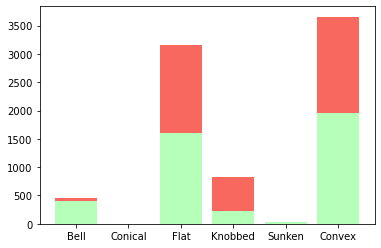

In [4]:
#cape-shape posınous and edıbles graphıcs

print (df.groupby(['cap-shape','class'])['class'].count())

bellEdible = df.groupby(['cap-shape','class'])['class'].count()[0]  
bellPosionus = df.groupby(['cap-shape','class'])['class'].count()[1]
bell = bellEdible + bellPosionus

conicalEdible = 0 #There is no Edible Conical data in our dataset 
conicalPosionus = df.groupby(['cap-shape','class'])['class'].count()[2] 
conical = conicalEdible + conicalPosionus

flatEdible = df.groupby(['cap-shape','class'])['class'].count()[3]  
flatPosionus = df.groupby(['cap-shape','class'])['class'].count()[4]
flat = flatEdible + flatPosionus

knobbedEdible = df.groupby(['cap-shape','class'])['class'].count()[5]  
knobbedPosionus = df.groupby(['cap-shape','class'])['class'].count()[6]
knobbed = knobbedEdible + knobbedPosionus

sunkenEdible = df.groupby(['cap-shape','class'])['class'].count()[7]  
sunkenPosinous  = 0 #There is no Sunken Posinous data in our dataset
sunken = sunkenEdible + sunkenPosinous

convexEdible = df.groupby(['cap-shape','class'])['class'].count()[8]  
convexPosionus = df.groupby(['cap-shape','class'])['class'].count()[9]
convex = convexEdible + convexPosionus

greenBars = [bellEdible, conicalEdible,  flatEdible, knobbedEdible, sunkenEdible, convexEdible]
redBars = [bellPosionus, conicalPosionus, flatPosionus, knobbedPosionus, sunkenPosinous, convexPosionus]

r = ['Bell', 'Conical', 'Flat', 'Knobbed','Sunken', 'Convex']
plt.bar(r, greenBars, color='#b5ffb9')
plt.bar(r, redBars, bottom=greenBars, color='#F9685F')


print('Bell cape-shape Mushrooms\'', bellEdible / bell * 100 ,'% are edible.')
print('Conical cape-shape Mushrooms\'', conicalEdible / conical * 100 ,'% are edible.')
print('Flat cape-shape Mushrooms\'', flatEdible / flat * 100 ,'% are edible.')
print('Knobbed cape-shape Mushrooms\'', knobbedEdible / knobbed * 100 ,'% are edible.')
print('Sunken cape-shape Mushrooms\'', sunkenEdible / sunken * 100 ,'% are edible.')
print('Convex cape-shape Mushrooms\'', convexEdible / convex * 100 ,'% are edible.')


cap-surface  class
f            e        1560
             p         760
g            p           4
s            e        1144
             p        1412
y            e        1504
             p        1740
Name: class, dtype: int64
Fibrous cape-surface Mushrooms' 67.24137931034483 % are edible.
Grooves cape-surface Mushrooms' 0.0 % are edible.
Scaly cape-surface Mushrooms' 44.75743348982786 % are edible.
Smooth cape-surface Mushrooms' 46.362515413070284 % are edible.


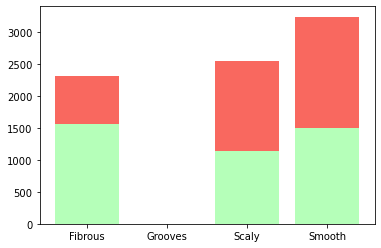

In [5]:
#cape-surface posınous and edıbles graphıcs

print (df.groupby(['cap-surface','class'])['class'].count())

fibrousEdible = df.groupby(['cap-surface','class'])['class'].count()[0]  
fibrousPosionus = df.groupby(['cap-surface','class'])['class'].count()[1]
fibrous = fibrousEdible + fibrousPosionus

groovesEdible = 0  
groovesPosionus = df.groupby(['cap-surface','class'])['class'].count()[2]
grooves = groovesEdible + groovesPosionus

scalyEdible = df.groupby(['cap-surface','class'])['class'].count()[3]  
scalyPosionus = df.groupby(['cap-surface','class'])['class'].count()[4]
scaly = scalyEdible + scalyPosionus

smoothEdible = df.groupby(['cap-surface','class'])['class'].count()[5]  
smoothPosionus = df.groupby(['cap-surface','class'])['class'].count()[6]
smooth = smoothEdible + smoothPosionus

greenBars = [fibrousEdible, groovesEdible,  scalyEdible, smoothEdible]
redBars = [fibrousPosionus, groovesPosionus, scalyPosionus, smoothPosionus]

r = ['Fibrous', 'Grooves', 'Scaly', 'Smooth']
plt.bar(r, greenBars, color='#b5ffb9')
plt.bar(r, redBars, bottom=greenBars, color='#F9685F')

print('Fibrous cape-surface Mushrooms\'', fibrousEdible / fibrous * 100 ,'% are edible.')
print('Grooves cape-surface Mushrooms\'', groovesEdible / grooves * 100 ,'% are edible.')
print('Scaly cape-surface Mushrooms\'', scalyEdible / scaly * 100 ,'% are edible.')
print('Smooth cape-surface Mushrooms\'', smoothEdible / smooth * 100 ,'% are edible.')



cap-color  class
b          e          48
           p         120
c          e          32
           p          12
e          e         624
           p         876
g          e        1032
           p         808
n          e        1264
           p        1020
p          e          56
           p          88
r          e          16
u          e          16
w          e         720
           p         320
y          e         400
           p         672
Name: class, dtype: int64
Buff cap-color Mushrooms' 28.57142857142857 % are edible.
Cinnamon cap-color Mushrooms' 72.72727272727273 % are edible.
Red cap-color Mushrooms' 41.6 % are edible.
Gray cap-color Mushrooms' 56.086956521739125 % are edible.
Brown cap-color Mushrooms' 55.34150612959719 % are edible.
Pink cap-color Mushrooms' 38.88888888888889 % are edible.
Green cap-color Mushrooms' 100.0 % are edible.
Purple cap-color Mushrooms' 100.0 % are edible.
White cap-color Mushrooms' 69.23076923076923 % are edible.
Yellow cap-co

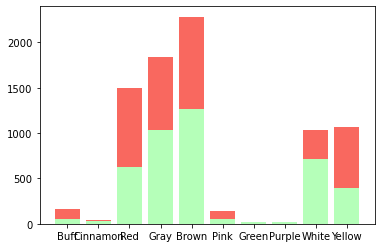

In [6]:
#cape-color posınous and edıbles graphıcs

print(df.groupby(['cap-color','class'])['class'].count())

buffEdible = df.groupby(['cap-color','class'])['class'].count()[0]  
buffPosionus = df.groupby(['cap-color','class'])['class'].count()[1]
buff = buffEdible + buffPosionus

cinnamonEdible = df.groupby(['cap-color','class'])['class'].count()[2]  
cinnamonPosionus = df.groupby(['cap-color','class'])['class'].count()[3]
cinnamon = cinnamonEdible + cinnamonPosionus


redEdible = df.groupby(['cap-color','class'])['class'].count()[4]  
redPosionus = df.groupby(['cap-color','class'])['class'].count()[5]
red = redEdible + redPosionus

grayEdible = df.groupby(['cap-color','class'])['class'].count()[6]  
grayPosionus = df.groupby(['cap-color','class'])['class'].count()[7]
gray = grayEdible + grayPosionus

brownEdible = df.groupby(['cap-color','class'])['class'].count()[8]  
brownPosionus = df.groupby(['cap-color','class'])['class'].count()[9]
brown = brownEdible + brownPosionus

pinkEdible = df.groupby(['cap-color','class'])['class'].count()[10]  
pinkPosionus = df.groupby(['cap-color','class'])['class'].count()[11]
pink = pinkEdible + pinkPosionus

greenEdible = df.groupby(['cap-color','class'])['class'].count()[12]  
greenPosionus = 0
green = greenEdible + greenPosionus

purpleEdible = df.groupby(['cap-color','class'])['class'].count()[13]  
purplePosionus = 0
purple = purpleEdible + purplePosionus


whiteEdible = df.groupby(['cap-color','class'])['class'].count()[14]  
whitePosionus = df.groupby(['cap-color','class'])['class'].count()[15]
white = whiteEdible + whitePosionus


yellowEdible = df.groupby(['cap-color','class'])['class'].count()[16]  
yellowPosionus = df.groupby(['cap-color','class'])['class'].count()[17]
yellow = yellowEdible + yellowPosionus

greenBars = [buffEdible, cinnamonEdible,  redEdible, grayEdible, brownEdible, pinkEdible, greenEdible, purpleEdible, whiteEdible, yellowEdible]
redBars =  [buffPosionus, cinnamonPosionus,  redPosionus, grayPosionus, brownPosionus, pinkPosionus, greenPosionus, purplePosionus, whitePosionus, yellowPosionus]

r = ['Buff', 'Cinnamon', 'Red', 'Gray','Brown', 'Pink','Green','Purple','White', 'Yellow']
plt.bar(r, greenBars, color='#b5ffb9')
plt.bar(r, redBars, bottom=greenBars, color='#F9685F')

print('Buff cap-color Mushrooms\'', buffEdible / buff * 100 ,'% are edible.')
print('Cinnamon cap-color Mushrooms\'', cinnamonEdible / cinnamon * 100 ,'% are edible.')
print('Red cap-color Mushrooms\'', redEdible / red * 100 ,'% are edible.')
print('Gray cap-color Mushrooms\'', grayEdible / gray * 100 ,'% are edible.')
print('Brown cap-color Mushrooms\'', brownEdible / brown * 100 ,'% are edible.')
print('Pink cap-color Mushrooms\'', pinkEdible / pink * 100 ,'% are edible.')
print('Green cap-color Mushrooms\'', greenEdible / green * 100 ,'% are edible.')
print('Purple cap-color Mushrooms\'', purpleEdible / purple * 100 ,'% are edible.')
print('White cap-color Mushrooms\'', whiteEdible / white * 100 ,'% are edible.')
print('Yellow cap-color Mushrooms\'', yellowEdible / yellow * 100 ,'% are edible.')

bruises  class
f        e        1456
         p        3292
t        e        2752
         p         624
Name: class, dtype: int64
Bruises Mushrooms' 30.66554338668913 % are edible.
Not Bruises Mushrooms' 81.51658767772511 % are edible.


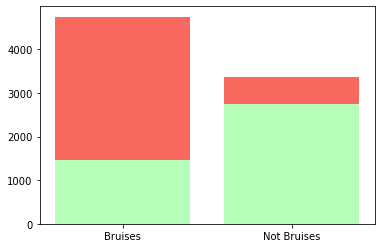

In [7]:
#Bruises posınous and edıbles graphıcs

print(df.groupby(['bruises','class'])['class'].count())

bruisesEdible = df.groupby(['bruises','class'])['class'].count()[0]  
bruisesPosionus = df.groupby(['bruises','class'])['class'].count()[1]
bruises = bruisesEdible + bruisesPosionus


notBruisesEdible = df.groupby(['bruises','class'])['class'].count()[2]  
notBruisesPosionus = df.groupby(['bruises','class'])['class'].count()[3]
notBruises = notBruisesEdible + notBruisesPosionus


greenBars = [bruisesEdible, notBruisesEdible]
redBars = [bruisesPosionus, notBruisesPosionus]

r = ['Bruises', 'Not Bruises']
plt.bar(r, greenBars, color='#b5ffb9')
plt.bar(r, redBars, bottom=greenBars, color='#F9685F')

print('Bruises Mushrooms\'', bruisesEdible / bruises * 100 ,'% are edible.')
print('Not Bruises Mushrooms\'', notBruisesEdible / notBruises * 100 ,'% are edible.')


odor  class
a     e         400
c     p         192
f     p        2160
l     e         400
m     p          36
n     e        3408
      p         120
p     p         256
s     p         576
y     p         576
Name: class, dtype: int64
Almond odor Mushrooms' 100.0 % are edible.
Creosote odor Mushrooms' 0.0 % are edible.
Foul odor Mushrooms' 0.0 % are edible.
Anise odor Mushrooms' 100.0 % are edible.
Musty odor Mushrooms' 0.0 % are edible.
None odor Mushrooms' 96.5986394557823 % are edible.
Pungent odor Mushrooms' 0.0 % are edible.
Spicy odor Mushrooms' 0.0 % are edible.
Fishy odor Mushrooms' 0.0 % are edible.


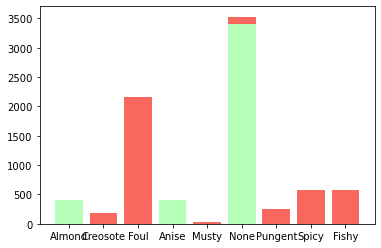

In [8]:
#odor mushrooms posınous and edıbles graphıcs

print(df.groupby(['odor','class'])['class'].count())

almondEdible = df.groupby(['odor','class'])['class'].count()[0]  
almondPosionus = 0
almond = almondEdible + almondPosionus


creosoteEdible = 0  
creosotePosionus = df.groupby(['odor','class'])['class'].count()[1]
creosote = creosoteEdible + creosotePosionus


foulEdible = 0 
foulPosionus = df.groupby(['odor','class'])['class'].count()[2]
foul = foulEdible + foulPosionus


aniseEdible = df.groupby(['odor','class'])['class'].count()[3]  
anisePosionus = 0
anise = aniseEdible + anisePosionus


mustyEdible = 0
mustyPosionus = df.groupby(['odor','class'])['class'].count()[4]
musty = mustyEdible + mustyPosionus


noneEdible = df.groupby(['odor','class'])['class'].count()[5]  
nonePosionus = df.groupby(['odor','class'])['class'].count()[6]
none = noneEdible + nonePosionus


pungentEdible = 0  
pungentPosionus = df.groupby(['odor','class'])['class'].count()[7]
pungent = pungentEdible + pungentPosionus


spicyEdible = 0
spicyPosionus = df.groupby(['odor','class'])['class'].count()[8]
spicy = spicyEdible + spicyPosionus


fishyEdible = 0 
fishyPosionus = df.groupby(['odor','class'])['class'].count()[9]
fishy = fishyEdible + fishyPosionus


greenBars = [almondEdible, creosoteEdible, foulEdible, aniseEdible, mustyEdible, noneEdible, pungentEdible, spicyEdible, fishyEdible]
redBars = [almondPosionus, creosotePosionus, foulPosionus, anisePosionus, mustyPosionus, nonePosionus, pungentPosionus, spicyPosionus, fishyPosionus]

r = ['Almond', 'Creosote', 'Foul','Anise', 'Musty', 'None', 'Pungent', 'Spicy', 'Fishy']
plt.bar(r, greenBars, color='#b5ffb9')
plt.bar(r, redBars, bottom=greenBars, color='#F9685F')

print('Almond odor Mushrooms\'', almondEdible / almond * 100 ,'% are edible.')
print('Creosote odor Mushrooms\'', creosoteEdible / creosote * 100 ,'% are edible.')
print('Foul odor Mushrooms\'', foulEdible / foul * 100 ,'% are edible.')
print('Anise odor Mushrooms\'', aniseEdible / anise * 100 ,'% are edible.')
print('Musty odor Mushrooms\'', mustyEdible / musty * 100 ,'% are edible.')
print('None odor Mushrooms\'', noneEdible / none * 100 ,'% are edible.')
print('Pungent odor Mushrooms\'', pungentEdible / pungent * 100 ,'% are edible.')
print('Spicy odor Mushrooms\'', spicyEdible /spicy * 100 ,'% are edible.')
print('Fishy odor Mushrooms\'', fishyEdible / fishy * 100 ,'% are edible.')


gill-attachment  class
a                e         192
                 p          18
f                e        4016
                 p        3898
Name: class, dtype: int64
Bruises Mushrooms' 91.42857142857143 % are edible.
Not Bruises Mushrooms' 50.74551427849381 % are edible.


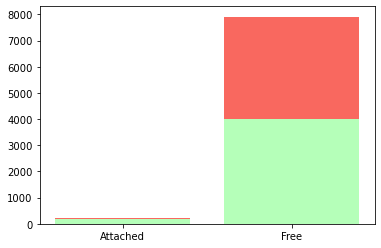

In [9]:
#Gill Attachment posınous and edıbles graphıcs

print(df.groupby(['gill-attachment','class'])['class'].count())

attachedEdible = df.groupby(['gill-attachment','class'])['class'].count()[0]  
attachedPosionus = df.groupby(['gill-attachment','class'])['class'].count()[1]
attached = attachedEdible + attachedPosionus


freeEdible = df.groupby(['gill-attachment','class'])['class'].count()[2]  
freePosionus = df.groupby(['gill-attachment','class'])['class'].count()[3]
free = freeEdible + freePosionus



greenBars = [attachedEdible, freeEdible]
redBars = [attachedPosionus, freePosionus]

r = ['Attached', 'Free']
plt.bar(r, greenBars, color='#b5ffb9')
plt.bar(r, redBars, bottom=greenBars, color='#F9685F')

print('Bruises Mushrooms\'', attachedEdible / attached * 100 ,'% are edible.')
print('Not Bruises Mushrooms\'', freeEdible / free * 100 ,'% are edible.')


gill-spacing  class
c             e        3008
              p        3804
w             e        1200
              p         112
Name: class, dtype: int64
Close gill-spacing Mushrooms' 44.157369348209045 % are edible.
Crowded gill-spacing Mushrooms' 50.74551427849381 % are edible.


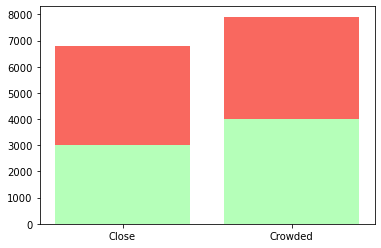

In [10]:
#Gill Spacing posinous and edibles graphics

print(df.groupby(['gill-spacing','class'])['class'].count())

closeEdible = df.groupby(['gill-spacing','class'])['class'].count()[0]  
closePosionus = df.groupby(['gill-spacing','class'])['class'].count()[1]
close = closeEdible + closePosionus


crowdedEdible = df.groupby(['gill-attachment','class'])['class'].count()[2]  
crowdedPosionus = df.groupby(['gill-attachment','class'])['class'].count()[3]
crowded = crowdedEdible + crowdedPosionus



greenBars = [closeEdible, crowdedEdible]
redBars = [closePosionus, crowdedPosionus]

r = ['Close', 'Crowded']
plt.bar(r, greenBars, color='#b5ffb9')
plt.bar(r, redBars, bottom=greenBars, color='#F9685F')

print('Close gill-spacing Mushrooms\'', closeEdible / close * 100 ,'% are edible.')
print('Crowded gill-spacing Mushrooms\'', crowdedEdible / crowded * 100 ,'% are edible.')

gill-size  class
b          e        3920
           p        1692
n          e         288
           p        2224
Name: class, dtype: int64
broad gill-spacing Mushrooms' 69.85032074126872 % are edible.
Crowded gill-spacing Mushrooms' 11.464968152866243 % are edible.


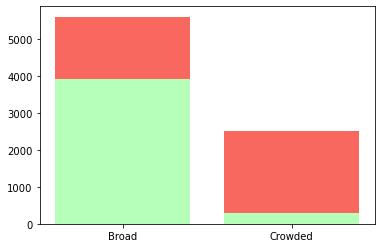

In [11]:
#Gill size posınous and edıbles graphıcs

print(df.groupby(['gill-size','class'])['class'].count())

broadEdible = df.groupby(['gill-size','class'])['class'].count()[0]  
broadPosionus = df.groupby(['gill-size','class'])['class'].count()[1]
broad = broadEdible + broadPosionus


narrowEdible = df.groupby(['gill-size','class'])['class'].count()[2]  
narrowPosionus = df.groupby(['gill-size','class'])['class'].count()[3]
narrow = narrowEdible + narrowPosionus



greenBars = [broadEdible, narrowEdible]
redBars = [broadPosionus, narrowPosionus]

r = ['Broad', 'Crowded']
plt.bar(r, greenBars, color='#b5ffb9')
plt.bar(r, redBars, bottom=greenBars, color='#F9685F')

print('broad gill-spacing Mushrooms\'', broadEdible / broad * 100 ,'% are edible.')
print('Crowded gill-spacing Mushrooms\'', narrowEdible / narrow * 100 ,'% are edible.')

gill-color  class
b           p        1728
e           e          96
g           e         248
            p         504
h           e         204
            p         528
k           e         344
            p          64
n           e         936
            p         112
o           e          64
p           e         852
            p         640
r           p          24
u           e         444
            p          48
w           e         956
            p         246
y           e          64
            p          22
Name: class, dtype: int64
Buff cap-color Mushrooms' 0.0 % are edible.
Red cap-color Mushrooms' 100.0 % are edible.
Gray cap-color Mushrooms' 32.97872340425532 % are edible.
Black cap-color Mushrooms' 84.31372549019608 % are edible.
Brown cap-color Mushrooms' 89.31297709923665 % are edible.
Orange cap-color Mushrooms' 100.0 % are edible.
Pink cap-color Mushrooms' 57.10455764075068 % are edible.
Green cap-color Mushrooms' 0.0 % are edible.
Purple cap-color Mus

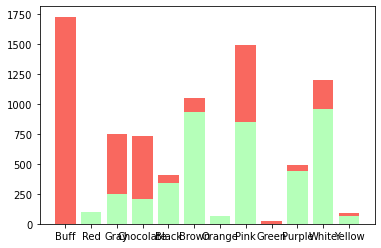

In [12]:
#Gill color posınous and edıbles graphıcs

print(df.groupby(['gill-color','class'])['class'].count())

buffGillEdible = 0 
buffGillPosionus = df.groupby(['gill-color','class'])['class'].count()[0]
buffGill = buffGillEdible + buffGillPosionus

redGillEdible = df.groupby(['gill-color','class'])['class'].count()[1]  
redGillPosionus = 0
redGill = redGillEdible + redGillPosionus

grayGillEdible = df.groupby(['gill-color','class'])['class'].count()[2]  
grayGillPosionus = df.groupby(['gill-color','class'])['class'].count()[3]
grayGill = grayGillEdible + grayGillPosionus

chocolateGillEdible = df.groupby(['gill-color','class'])['class'].count()[4]  
chocolateGillPosionus = df.groupby(['gill-color','class'])['class'].count()[5]
chocolateGill = chocolateGillEdible + chocolateGillPosionus

blackGillEdible = df.groupby(['gill-color','class'])['class'].count()[6]  
blackGillPosionus = df.groupby(['gill-color','class'])['class'].count()[7]
blackGill = blackGillEdible + blackGillPosionus

brownGillEdible = df.groupby(['gill-color','class'])['class'].count()[8]  
brownGillPosionus = df.groupby(['gill-color','class'])['class'].count()[9]
brownGill = brownGillEdible + brownGillPosionus

orangeGillEdible = df.groupby(['gill-color','class'])['class'].count()[10]  
orangeGillPosionus = 0
orangeGill = orangeGillEdible + orangeGillPosionus

pinkGillEdible = df.groupby(['gill-color','class'])['class'].count()[11]  
pinkGillPosionus = df.groupby(['gill-color','class'])['class'].count()[12]
pinkGill = pinkGillEdible + pinkGillPosionus


greenGillEdible = 0 
greenGillPosionus = df.groupby(['gill-color','class'])['class'].count()[13]
greenGill = greenGillEdible + greenGillPosionus


purpleGillEdible = df.groupby(['gill-color','class'])['class'].count()[14]  
purpleGillPosionus = df.groupby(['gill-color','class'])['class'].count()[15]
purpleGill = purpleGillEdible + purpleGillPosionus

whiteGillEdible = df.groupby(['gill-color','class'])['class'].count()[16]  
whiteGillPosionus = df.groupby(['gill-color','class'])['class'].count()[17]
whiteGill = whiteGillEdible + whiteGillPosionus

yellowGillEdible = df.groupby(['gill-color','class'])['class'].count()[18]  
yellowGillPosionus = df.groupby(['gill-color','class'])['class'].count()[19]
yellowGill = yellowGillEdible + yellowGillPosionus





greenBars = [buffGillEdible, redGillEdible,  grayGillEdible, chocolateGillEdible, blackGillEdible, brownGillEdible, orangeGillEdible, pinkGillEdible, greenGillEdible, purpleGillEdible, whiteGillEdible, yellowGillEdible]
redBars =  [buffGillPosionus, redGillPosionus,  grayGillPosionus, chocolateGillPosionus, blackGillPosionus, brownGillPosionus, orangeGillPosionus, pinkGillPosionus, greenGillPosionus, purpleGillPosionus, whiteGillPosionus, yellowGillPosionus]

r = ['Buff', 'Red', 'Gray','Chocolate', 'Black','Brown','Orange', 'Pink','Green','Purple','White', 'Yellow']
plt.bar(r, greenBars, color='#b5ffb9')
plt.bar(r, redBars, bottom=greenBars, color='#F9685F')


print('Buff cap-color Mushrooms\'', buffGillEdible / buffGill * 100 ,'% are edible.')
print('Red cap-color Mushrooms\'', redGillEdible / redGill * 100 ,'% are edible.')
print('Gray cap-color Mushrooms\'', grayGillEdible / grayGill * 100 ,'% are edible.')
print('Black cap-color Mushrooms\'', blackGillEdible / blackGill * 100 ,'% are edible.')
print('Brown cap-color Mushrooms\'', brownGillEdible / brownGill * 100 ,'% are edible.')
print('Orange cap-color Mushrooms\'', orangeGillEdible / orangeGill * 100 ,'% are edible.')
print('Pink cap-color Mushrooms\'', pinkGillEdible / pinkGill * 100 ,'% are edible.')
print('Green cap-color Mushrooms\'', greenGillEdible / greenGill * 100 ,'% are edible.')
print('Purple cap-color Mushrooms\'', purpleGillEdible / purpleGill * 100 ,'% are edible.')
print('White cap-color Mushrooms\'', whiteGillEdible / whiteGill * 100 ,'% are edible.')
print('Yellow cap-color Mushrooms\'', yellowGillEdible / yellowGill * 100 ,'% are edible.')



stalk-shape  class
e            e        1616
             p        1900
t            e        2592
             p        2016
Name: class, dtype: int64
Enlarging stalk-shape Mushrooms' 45.961319681456196 % are edible.
Tapering stalk-shape Mushrooms' 56.25 % are edible.


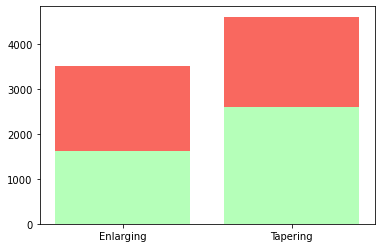

In [13]:
#Stalk shape posınous and edıbles graphıcs

print(df.groupby(['stalk-shape','class'])['class'].count())

enlargingEdible = df.groupby(['stalk-shape','class'])['class'].count()[0]  
enlargingPosionus = df.groupby(['stalk-shape','class'])['class'].count()[1]
enlarging = enlargingEdible + enlargingPosionus


taperingEdible = df.groupby(['stalk-shape','class'])['class'].count()[2]  
taperingPosionus = df.groupby(['stalk-shape','class'])['class'].count()[3]
tapering = taperingEdible + taperingPosionus


greenBars = [enlargingEdible, taperingEdible]
redBars = [enlargingPosionus, taperingPosionus]

r = ['Enlarging', 'Tapering']
plt.bar(r, greenBars, color='#b5ffb9')
plt.bar(r, redBars, bottom=greenBars, color='#F9685F')

print('Enlarging stalk-shape Mushrooms\'', enlargingEdible / enlarging * 100 ,'% are edible.')
print('Tapering stalk-shape Mushrooms\'', taperingEdible / tapering * 100 ,'% are edible.')

stalk-root  class
b           e        1920
            p        1856
c           e         512
            p          44
e           e         864
            p         256
r           e         192
Name: class, dtype: int64
Bulbous stalk-root Mushrooms' 50.847457627118644 % are edible.
Club stalk-root Mushrooms' 92.08633093525181 % are edible.
Equal stalk-root Mushrooms' 77.14285714285715 % are edible.
Rooted stalk-root Mushrooms' 0.0 % are edible.


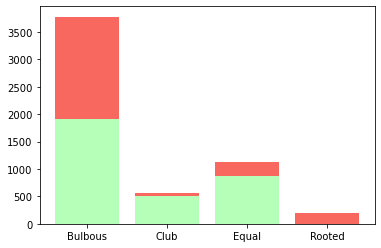

In [14]:
#Stalk Root posınous and edıbles graphıcs

print(df.groupby(['stalk-root','class'])['class'].count())

bulbousEdible = df.groupby(['stalk-root','class'])['class'].count()[0]  
bulbousPosionus = df.groupby(['stalk-root','class'])['class'].count()[1]
bulbous = bulbousEdible + bulbousPosionus


clubEdible = df.groupby(['stalk-root','class'])['class'].count()[2]  
clubPosionus = df.groupby(['stalk-root','class'])['class'].count()[3]
club = clubEdible + clubPosionus

equalEdible = df.groupby(['stalk-root','class'])['class'].count()[4]  
equalPosionus = df.groupby(['stalk-root','class'])['class'].count()[5]
equal = equalEdible + equalPosionus

rootedEdible = 0  
rootedPosionus = df.groupby(['stalk-root','class'])['class'].count()[6]
rooted = rootedEdible + rootedPosionus


greenBars = [bulbousEdible, clubEdible, equalEdible, rootedEdible]
redBars = [bulbousPosionus, clubPosionus, equalPosionus, rootedPosionus]

r = ['Bulbous', 'Club','Equal','Rooted']
plt.bar(r, greenBars, color='#b5ffb9')
plt.bar(r, redBars, bottom=greenBars, color='#F9685F')

print('Bulbous stalk-root Mushrooms\'', bulbousEdible / bulbous * 100 ,'% are edible.')
print('Club stalk-root Mushrooms\'', clubEdible / club * 100 ,'% are edible.')
print('Equal stalk-root Mushrooms\'', equalEdible / equal * 100 ,'% are edible.')
print('Rooted stalk-root Mushrooms\'', rootedEdible / rooted * 100 ,'% are edible.')

stalk-surface-above-ring  class
f                         e         408
                          p         144
k                         e         144
                          p        2228
s                         e        3640
                          p        1536
y                         e          16
                          p           8
Name: class, dtype: int64
fibrous stalk-surface-above-ring Mushrooms' 73.91304347826086 % are edible.
silky stalk-surface-above-ring Mushrooms' 6.070826306913997 % are edible.
smooth stalk-surface-above-ring Mushrooms' 70.32457496136011 % are edible.
scaly stalk-surface-above-ring Mushrooms' 8.333333333333332 % are edible.


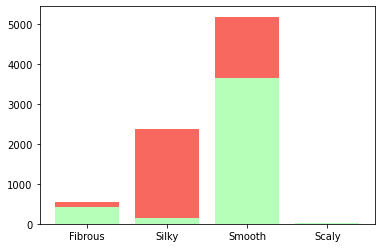

In [15]:
#Stalk surface above ring posınous and edıbles graphıcs

print (df.groupby(['stalk-surface-above-ring','class'])['class'].count())


fibrousEdible = df.groupby(['stalk-surface-above-ring','class'])['class'].count()[0]  
fibrousPosionus = df.groupby(['stalk-surface-above-ring','class'])['class'].count()[1]
fibrous = fibrousEdible + fibrousPosionus

silkyEdible = df.groupby(['stalk-surface-above-ring','class'])['class'].count()[2]  
silkyPosionus = df.groupby(['stalk-surface-above-ring','class'])['class'].count()[3]
silky = silkyEdible + silkyPosionus

smoothEdible = df.groupby(['stalk-surface-above-ring','class'])['class'].count()[4]  
smoothPosionus = df.groupby(['stalk-surface-above-ring','class'])['class'].count()[5]
smooth = smoothEdible + smoothPosionus

scalyEdible = df.groupby(['stalk-surface-above-ring','class'])['class'].count()[6]  
scalyPosionus = df.groupby(['stalk-surface-above-ring','class'])['class'].count()[7]
scaly = scalyEdible + scalyPosionus

greenBars = [fibrousEdible, silkyEdible, smoothEdible, scalyEdible]
redBars = [fibrousPosionus, silkyPosionus, smoothPosionus, scalyPosionus]

r = ['Fibrous', 'Silky','Smooth','Scaly']
plt.bar(r, greenBars, color='#b5ffb9')
plt.bar(r, redBars, bottom=greenBars, color='#F9685F')

print('fibrous stalk-surface-above-ring Mushrooms\'', fibrousEdible / fibrous * 100 ,'% are edible.')
print('silky stalk-surface-above-ring Mushrooms\'', silkyEdible / silky * 100 ,'% are edible.')
print('smooth stalk-surface-above-ring Mushrooms\'', smoothEdible / smooth * 100 ,'% are edible.')
print('scaly stalk-surface-above-ring Mushrooms\'', scalyEdible / rooted * 100 ,'% are edible.')


stalk-surface-below-ring  class
f                         e         456
                          p         144
k                         e         144
                          p        2160
s                         e        3400
                          p        1536
y                         e         208
                          p          76
Name: class, dtype: int64
Fibrous stalk-surface-above-ring Mushrooms' 73.91304347826086 % are edible.
ilky stalk-surface-above-ring Mushrooms' 6.070826306913997 % are edible.
smooth stalk-surface-above-ring Mushrooms' 70.32457496136011 % are edible.
scaly stalk-surface-above-ring Mushrooms' 8.333333333333332 % are edible.


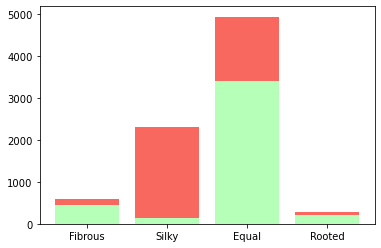

In [16]:
#Stalk survace below ring posınous and edıbles graphıcs

print (df.groupby(['stalk-surface-below-ring','class'])['class'].count())

fibrousSurfaceEdible = df.groupby(['stalk-surface-below-ring','class'])['class'].count()[0]  
fibrousSurfacePosionus = df.groupby(['stalk-surface-below-ring','class'])['class'].count()[1]
fibrousSurface = fibrousSurfaceEdible + fibrousSurfacePosionus

silkySurfaceEdible = df.groupby(['stalk-surface-below-ring','class'])['class'].count()[2]  
silkySurfacePosionus = df.groupby(['stalk-surface-below-ring','class'])['class'].count()[3]
silkySurface = silkySurfaceEdible + silkySurfacePosionus

smoothSurfaceEdible = df.groupby(['stalk-surface-below-ring','class'])['class'].count()[4]  
smoothSurfacePosionus = df.groupby(['stalk-surface-below-ring','class'])['class'].count()[5]
smoothSurface = smoothSurfaceEdible + smoothSurfacePosionus

scalySurfaceEdible = df.groupby(['stalk-surface-below-ring','class'])['class'].count()[6]  
scalySurfacePosionus = df.groupby(['stalk-surface-below-ring','class'])['class'].count()[7]
scalySurface = scalySurfaceEdible + scalySurfacePosionus

greenBars = [fibrousSurfaceEdible, silkySurfaceEdible, smoothSurfaceEdible, scalySurfaceEdible]
redBars = [fibrousSurfacePosionus, silkySurfacePosionus, smoothSurfacePosionus, scalySurfacePosionus]

r = ['Fibrous', 'Silky','Equal','Rooted']
plt.bar(r, greenBars, color='#b5ffb9')
plt.bar(r, redBars, bottom=greenBars, color='#F9685F')

print('Fibrous stalk-surface-above-ring Mushrooms\'', fibrousEdible / fibrous * 100 ,'% are edible.')
print('ilky stalk-surface-above-ring Mushrooms\'', silkyEdible / silky * 100 ,'% are edible.')
print('smooth stalk-surface-above-ring Mushrooms\'', smoothEdible / smooth * 100 ,'% are edible.')
print('scaly stalk-surface-above-ring Mushrooms\'', scalyEdible / rooted * 100 ,'% are edible.')



stalk-color-below-ring  class
b                       p         432
c                       p          36
e                       e          96
g                       e         576
n                       e          64
                        p         448
o                       e         192
p                       e         576
                        p        1296
w                       e        2704
                        p        1680
y                       p          24
Name: class, dtype: int64
Buff stalk-color-below-ring Mushrooms' 0.0 % are edible.
Cinnamon stalk-color-below-ring Mushrooms' 0.0 % are edible.
Red stalk-color-below-ring Mushrooms' 100.0 % are edible.
Gray stalk-color-below-ring Mushrooms' 100.0 % are edible.
Brown stalk-color-below-ring Mushrooms' 12.5 % are edible.
Orange stalk-color-below-ring Mushrooms' 100.0 % are edible.
Pink stalk-color-below-ring Mushrooms' 30.76923076923077 % are edible.
White stalk-color-below-ring Mushrooms' 61.67883211678832 % ar

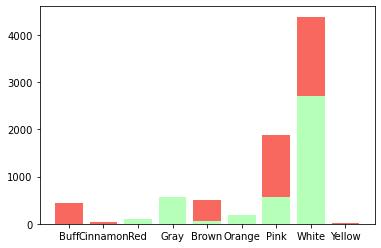

In [17]:
#Stalk color below ring posınous and edıbles graphıcs

print(df.groupby(['stalk-color-below-ring','class'])['class'].count())

buffbelowEdible = 0 
buffbelowPosionus = df.groupby(['stalk-color-below-ring','class'])['class'].count()[0]
buffbelow = buffbelowEdible + buffbelowPosionus

cinnamonbelowEdible = 0
cinnamonbelowPosionus = df.groupby(['stalk-color-below-ring','class'])['class'].count()[1]
cinnamonbelow = cinnamonbelowEdible + cinnamonbelowPosionus

redbelowEdible = df.groupby(['stalk-color-below-ring','class'])['class'].count()[2]
redbelowPosionus = 0
redbelow = redbelowEdible + redbelowPosionus

graybelowEdible = df.groupby(['stalk-color-below-ring','class'])['class'].count()[3]
graybelowPosionus = 0
graybelow = graybelowEdible + graybelowPosionus

brownbelowEdible = df.groupby(['stalk-color-below-ring','class'])['class'].count()[4]
brownbelowPosionus = df.groupby(['stalk-color-below-ring','class'])['class'].count()[5]
brownbelow = brownbelowEdible + brownbelowPosionus

orangebelowEdible = df.groupby(['stalk-color-below-ring','class'])['class'].count()[6]
orangebelowPosionus = 0
orangebelow = orangebelowEdible + orangebelowPosionus

pinkbelowEdible = df.groupby(['stalk-color-below-ring','class'])['class'].count()[7]
pinkbelowPosionus = df.groupby(['stalk-color-below-ring','class'])['class'].count()[8]
pinkbelow = pinkbelowEdible + pinkbelowPosionus

whitebelowEdible = df.groupby(['stalk-color-below-ring','class'])['class'].count()[9]
whitebelowPosionus = df.groupby(['stalk-color-below-ring','class'])['class'].count()[10]
whitebelow = whitebelowEdible + whitebelowPosionus

yellowbelowEdible = 0
yellowbelowPosionus = df.groupby(['stalk-color-below-ring','class'])['class'].count()[11]
yellowbelow = yellowbelowEdible + yellowbelowPosionus

greenBars = [buffbelowEdible, cinnamonbelowEdible,  redbelowEdible, graybelowEdible, brownbelowEdible, orangebelowEdible, pinkbelowEdible, whitebelowEdible, yellowbelowEdible]
redBars =  [buffbelowPosionus, cinnamonbelowPosionus,  redbelowPosionus, graybelowPosionus, brownbelowPosionus, orangebelowPosionus, pinkbelowPosionus, whitebelowPosionus, yellowbelowPosionus]

r = ['Buff','Cinnamon', 'Red', 'Gray','Brown','Orange', 'Pink', 'White', 'Yellow']
plt.bar(r, greenBars, color='#b5ffb9')
plt.bar(r, redBars, bottom=greenBars, color='#F9685F')


print('Buff stalk-color-below-ring Mushrooms\'', buffbelowEdible / buffbelow * 100 ,'% are edible.')
print('Cinnamon stalk-color-below-ring Mushrooms\'', cinnamonbelowEdible / cinnamonbelow * 100 ,'% are edible.')
print('Red stalk-color-below-ring Mushrooms\'', redbelowEdible / redbelow * 100 ,'% are edible.')
print('Gray stalk-color-below-ring Mushrooms\'', graybelowEdible / graybelow * 100 ,'% are edible.')
print('Brown stalk-color-below-ring Mushrooms\'', brownbelowEdible / brownbelow * 100 ,'% are edible.')
print('Orange stalk-color-below-ring Mushrooms\'', orangebelowEdible / orangebelow * 100 ,'% are edible.')
print('Pink stalk-color-below-ring Mushrooms\'', pinkbelowEdible / pinkbelow * 100 ,'% are edible.')
print('White stalk-color-below-ring Mushrooms\'', whitebelowEdible / whitebelow * 100 ,'% are edible.')
print('Purple stalk-color-below-ring Mushrooms\'', yellowbelowEdible / yellowbelow * 100 ,'% are edible.')

stalk-color-above-ring  class
b                       p         432
c                       p          36
e                       e          96
g                       e         576
n                       e          16
                        p         432
o                       e         192
p                       e         576
                        p        1296
w                       e        2752
                        p        1712
y                       p           8
Name: class, dtype: int64
Buff stalk-color-above-ring Mushrooms' 0.0 % are edible.
Cinnamon stalk-color-above-ring Mushrooms' 0.0 % are edible.
Red stalk-color-above-ring Mushrooms' 100.0 % are edible.
Gray stalk-color-above-ring Mushrooms' 100.0 % are edible.
Brown stalk-color-above-ring Mushrooms' 3.571428571428571 % are edible.
Orange stalk-color-above-ring Mushrooms' 100.0 % are edible.
Pink stalk-color-above-ring Mushrooms' 30.76923076923077 % are edible.
White stalk-color-above-ring Mushrooms' 61.648745

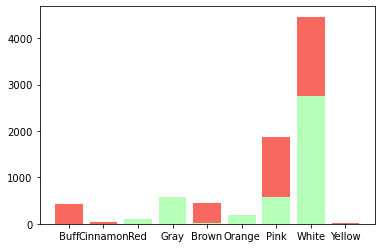

In [18]:
#Stalk color above ring posınous and edıbles graphıcs

print(df.groupby(['stalk-color-above-ring','class'])['class'].count())

buffStalkEdible = 0 
buffStalkPosionus = df.groupby(['stalk-color-above-ring','class'])['class'].count()[0]
buffStalk = buffStalkEdible + buffStalkPosionus

cinnamonStalkEdible = 0
cinnamonStalkPosionus = df.groupby(['stalk-color-above-ring','class'])['class'].count()[1]
cinnamonStalk = cinnamonStalkEdible + cinnamonStalkPosionus

redStalkEdible = df.groupby(['stalk-color-above-ring','class'])['class'].count()[2]
redStalkPosionus = 0
redStalk = redStalkEdible + redStalkPosionus

grayStalkEdible = df.groupby(['stalk-color-above-ring','class'])['class'].count()[3]
grayStalkPosionus = 0
grayStalk = grayStalkEdible + grayStalkPosionus

brownStalkEdible = df.groupby(['stalk-color-above-ring','class'])['class'].count()[4]
brownStalkPosionus = df.groupby(['stalk-color-above-ring','class'])['class'].count()[5]
brownStalk = brownStalkEdible + brownStalkPosionus

orangeStalkEdible = df.groupby(['stalk-color-above-ring','class'])['class'].count()[6]
orangeStalkPosionus = 0
orangeStalk = orangeStalkEdible + orangeStalkPosionus

pinkStalkEdible = df.groupby(['stalk-color-above-ring','class'])['class'].count()[7]
pinkStalkPosionus = df.groupby(['stalk-color-above-ring','class'])['class'].count()[8]
pinkStalk = pinkStalkEdible + pinkStalkPosionus

whiteStalkEdible = df.groupby(['stalk-color-above-ring','class'])['class'].count()[9]
whiteStalkPosionus = df.groupby(['stalk-color-above-ring','class'])['class'].count()[10]
whiteStalk = whiteStalkEdible + whiteStalkPosionus

yellowStalkEdible = 0
yellowStalkPosionus = df.groupby(['stalk-color-above-ring','class'])['class'].count()[11]
yellowStalk = yellowStalkEdible + yellowStalkPosionus

greenBars = [buffStalkEdible, cinnamonStalkEdible,  redStalkEdible, grayStalkEdible, brownStalkEdible, orangeStalkEdible, pinkStalkEdible, whiteStalkEdible, yellowStalkEdible]
redBars =  [buffStalkPosionus, cinnamonStalkPosionus,  redStalkPosionus, grayStalkPosionus, brownStalkPosionus, orangeStalkPosionus, pinkStalkPosionus, whiteStalkPosionus, yellowStalkPosionus]

r = ['Buff','Cinnamon', 'Red', 'Gray','Brown','Orange', 'Pink', 'White', 'Yellow']
plt.bar(r, greenBars, color='#b5ffb9')
plt.bar(r, redBars, bottom=greenBars, color='#F9685F')


print('Buff stalk-color-above-ring Mushrooms\'', buffStalkEdible / buffStalk * 100 ,'% are edible.')
print('Cinnamon stalk-color-above-ring Mushrooms\'', cinnamonStalkEdible / cinnamonStalk * 100 ,'% are edible.')
print('Red stalk-color-above-ring Mushrooms\'', redStalkEdible / redStalk * 100 ,'% are edible.')
print('Gray stalk-color-above-ring Mushrooms\'', grayStalkEdible / grayStalk * 100 ,'% are edible.')
print('Brown stalk-color-above-ring Mushrooms\'', brownStalkEdible / brownStalk * 100 ,'% are edible.')
print('Orange stalk-color-above-ring Mushrooms\'', orangeStalkEdible / orangeStalk * 100 ,'% are edible.')
print('Pink stalk-color-above-ring Mushrooms\'', pinkStalkEdible / pinkStalk * 100 ,'% are edible.')
print('White stalk-color-above-ring Mushrooms\'', whiteStalkEdible / whiteStalk * 100 ,'% are edible.')
print('Purple stalk-color-above-ring Mushrooms\'', yellowStalkEdible / yellowStalk * 100 ,'% are edible.')

veil-type  class
p          e        4208
           p        3916
Name: class, dtype: int64
Partial veil-type Mushrooms' 51.7971442639094 % are edible.


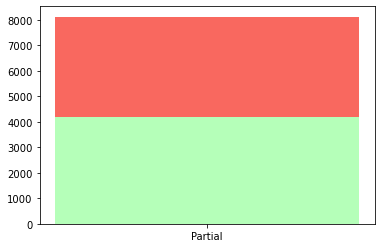

In [19]:
#Veil posınous and edıbles graphıcs

print(df.groupby(['veil-type','class'])['class'].count())

partialEdible = df.groupby(['veil-type','class'])['class'].count()[0]  
partialPosionus = df.groupby(['veil-type','class'])['class'].count()[1]
partial = partialEdible + partialPosionus


greenBars = [partialEdible]
redBars = [partialPosionus]

r = ['Partial']
plt.bar(r, greenBars, color='#b5ffb9')
plt.bar(r, redBars, bottom=greenBars, color='#F9685F')

print('Partial veil-type Mushrooms\'', partialEdible / partial * 100 ,'% are edible.')


veil-color  class
n           e          96
o           e          96
w           e        4016
            p        3908
y           p           8
Name: class, dtype: int64
Brown veil-color Mushrooms' 100.0 % are edible.
Orange veil-color Mushrooms' 100.0 % are edible.
White veil-color Mushrooms' 50.68147400302877 % are edible.
Yellow veil-color Mushrooms' 0.0 % are edible.


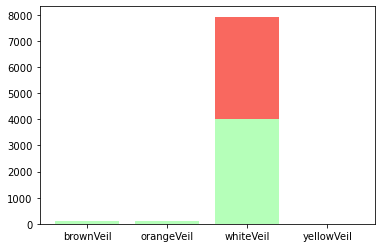

In [20]:
#Veil color posınous and edıbles graphıcs

print (df.groupby(['veil-color','class'])['class'].count())



brownVeilEdible = df.groupby(['veil-color','class'])['class'].count()[0]  
brownVeilPosionus = 0
brownVeil = brownVeilEdible + brownVeilPosionus


orangeVeilEdible = df.groupby(['veil-color','class'])['class'].count()[1]  
orangeVeilPosionus = 0
orangeVeil = orangeVeilEdible + orangeVeilPosionus


whiteVeilEdible = df.groupby(['veil-color','class'])['class'].count()[2]  
whiteVeilPosionus = df.groupby(['veil-color','class'])['class'].count()[3]
whiteVeil = whiteVeilEdible + whiteVeilPosionus


yellowVeilEdible = 0
yellowVeilPosionus = df.groupby(['veil-color','class'])['class'].count()[4]
yellowVeil = yellowVeilEdible + yellowVeilPosionus

greenBars = [brownVeilEdible, orangeVeilEdible, whiteVeilEdible, yellowVeilEdible]
redBars = [brownVeilPosionus, orangeVeilPosionus, whiteVeilPosionus, yellowVeilPosionus]

r = ['brownVeil', 'orangeVeil','whiteVeil','yellowVeil']
plt.bar(r, greenBars, color='#b5ffb9')
plt.bar(r, redBars, bottom=greenBars, color='#F9685F')

print('Brown veil-color Mushrooms\'', brownVeilEdible / brownVeil * 100 ,'% are edible.')
print('Orange veil-color Mushrooms\'', orangeVeilEdible / orangeVeil * 100 ,'% are edible.')
print('White veil-color Mushrooms\'', whiteVeilEdible / whiteVeil * 100 ,'% are edible.')
print('Yellow veil-color Mushrooms\'', yellowVeilEdible / yellowVeil * 100 ,'% are edible.')



ring-number  class
n            p          36
o            e        3680
             p        3808
t            e         528
             p          72
Name: class, dtype: int64
None ring Mushrooms' 0.0 % are edible.
One ring Mushrooms' 49.14529914529914 % are edible.
Two ring Mushrooms' 88.0 % are edible.


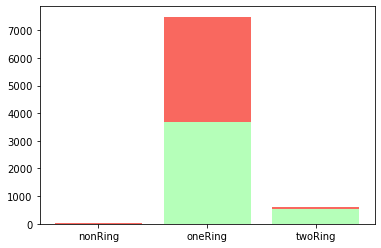

In [21]:
#Ring number posınous and edıbles graphıcs

print (df.groupby(['ring-number','class'])['class'].count())



nonRingEdible = 0 
nonRingPosionus = df.groupby(['ring-number','class'])['class'].count()[0] 
nonRing = nonRingEdible + nonRingPosionus


oneRingEdible = df.groupby(['ring-number','class'])['class'].count()[1]  
oneRingPosionus = df.groupby(['ring-number','class'])['class'].count()[2] 
oneRing = oneRingEdible + oneRingPosionus


twoRingEdible = df.groupby(['ring-number','class'])['class'].count()[3]  
twoRingPosionus = df.groupby(['ring-number','class'])['class'].count()[4]
twoRing = twoRingEdible + twoRingPosionus


greenBars = [nonRingEdible, oneRingEdible, twoRingEdible]
redBars = [nonRingPosionus, oneRingPosionus, twoRingPosionus]

r = ['nonRing', 'oneRing','twoRing']
plt.bar(r, greenBars, color='#b5ffb9')
plt.bar(r, redBars, bottom=greenBars, color='#F9685F')

print('None ring Mushrooms\'', nonRingEdible / nonRing * 100 ,'% are edible.')
print('One ring Mushrooms\'', oneRingEdible / oneRing * 100 ,'% are edible.')
print('Two ring Mushrooms\'', twoRingEdible / twoRing * 100 ,'% are edible.')



ring-type  class
e          e        1008
           p        1768
f          e          48
l          p        1296
n          p          36
p          e        3152
           p         816
Name: class, dtype: int64
Evanescent ring-type Mushrooms' 36.31123919308357 % are edible.
Flaring ring-type Mushrooms' 100.0 % are edible.
LargeRing ring-type Mushrooms' 0.0 % are edible.
None ring-type Mushrooms' 0.0 % are edible.
Pendant ring-type Mushrooms' 79.43548387096774 % are edible.


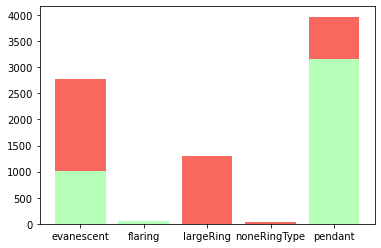

In [22]:
#Ring type posınous and edıbles graphıcs

print (df.groupby(['ring-type','class'])['class'].count())



evanescentEdible = df.groupby(['ring-type','class'])['class'].count()[0]  
evanescentPosionus = df.groupby(['ring-type','class'])['class'].count()[1] 
evanescent = evanescentEdible + evanescentPosionus


flaringEdible = df.groupby(['ring-type','class'])['class'].count()[2]  
flaringPosionus = 0
flaring = flaringEdible + flaringPosionus


largeRingEdible = 0
largeRingPosionus = df.groupby(['ring-type','class'])['class'].count()[3]
largeRing = largeRingEdible + largeRingPosionus


noneRingTypeEdible = 0
noneRingTypePosionus = df.groupby(['ring-type','class'])['class'].count()[4]
noneRingType = noneRingTypeEdible + noneRingTypePosionus

pendantEdible = df.groupby(['ring-type','class'])['class'].count()[5]
pendantPosionus = df.groupby(['ring-type','class'])['class'].count()[6]
pendant = pendantEdible + pendantPosionus


greenBars = [evanescentEdible, flaringEdible, largeRingEdible,noneRingTypeEdible, pendantEdible]
redBars = [evanescentPosionus, flaringPosionus, largeRingPosionus,noneRingTypePosionus, pendantPosionus]

r = ['evanescent', 'flaring','largeRing','noneRingType', 'pendant']
plt.bar(r, greenBars, color='#b5ffb9')
plt.bar(r, redBars, bottom=greenBars, color='#F9685F')

print('Evanescent ring-type Mushrooms\'', evanescentEdible / evanescent * 100 ,'% are edible.')
print('Flaring ring-type Mushrooms\'', flaringEdible / flaring * 100 ,'% are edible.')
print('LargeRing ring-type Mushrooms\'', largeRingEdible / largeRing * 100 ,'% are edible.')
print('None ring-type Mushrooms\'', noneRingTypeEdible / noneRingType * 100 ,'% are edible.')
print('Pendant ring-type Mushrooms\'', pendantEdible / pendant * 100 ,'% are edible.')



spore-print-color  class
b                  e          48
h                  e          48
                   p        1584
k                  e        1648
                   p         224
n                  e        1744
                   p         224
o                  e          48
r                  p          72
u                  e          48
w                  e         576
                   p        1812
y                  e          48
Name: class, dtype: int64
Buff spore-print-color Mushrooms' 100.0 % are edible.
chocolate spore-print-color Mushrooms' 100.0 % are edible.
black spore-print-color Mushrooms' 49.00990099009901 % are edible.
green spore-print-color Mushrooms' 0.0 % are edible.
Brown spore-print-color Mushrooms' 11.38211382113821 % are edible.
Orange spore-print-color Mushrooms' 100.0 % are edible.
Purple spore-print-color Mushrooms' 100.0 % are edible.
White spore-print-color Mushrooms' 60.0 % are edible.
Yellow spore-print-color Mushrooms' 100.0 % are edible

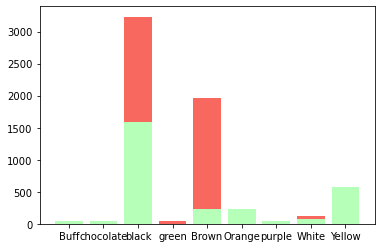

In [23]:
#Spore print color posınous and edıbles graphıcs


print(df.groupby(['spore-print-color','class'])['class'].count())

buffsporeEdible = df.groupby(['spore-print-color','class'])['class'].count()[0] 
buffsporePosionus = 0
buffspore = buffsporeEdible + buffsporePosionus

chocolatesporeEdible = df.groupby(['spore-print-color','class'])['class'].count()[1]
chocolatesporePosionus = 0
chocolatespore = chocolatesporeEdible + chocolatesporePosionus

blacksporeEdible = df.groupby(['spore-print-color','class'])['class'].count()[2]
blacksporePosionus = df.groupby(['spore-print-color','class'])['class'].count()[3]
blackspore = blacksporeEdible + blacksporePosionus

brownsporeEdible = df.groupby(['spore-print-color','class'])['class'].count()[4]
brownsporePosionus = df.groupby(['spore-print-color','class'])['class'].count()[5]
brownspore = brownsporeEdible + brownsporePosionus


orangesporeEdible = df.groupby(['spore-print-color','class'])['class'].count()[6]
orangesporePosionus = 0
orangespore = orangesporeEdible + orangesporePosionus


greensporeEdible = 0
greensporePosionus = df.groupby(['spore-print-color','class'])['class'].count()[7]
greenspore = greensporeEdible + greensporePosionus


purplesporeEdible = df.groupby(['spore-print-color','class'])['class'].count()[7]
purplesporePosionus = 0
purplespore = purplesporeEdible + purplesporePosionus

whitesporeEdible = df.groupby(['spore-print-color','class'])['class'].count()[8]
whitesporePosionus = df.groupby(['spore-print-color','class'])['class'].count()[9]
whitespore = whitesporeEdible + whitesporePosionus

yellowsporeEdible = df.groupby(['spore-print-color','class'])['class'].count()[10]
yellowsporePosionus = 0
yellowspore = yellowsporeEdible + yellowsporePosionus

greenBars = [buffsporeEdible, chocolatesporeEdible,  blacksporeEdible, greensporeEdible, brownsporeEdible, orangesporeEdible, purplesporeEdible, whitesporeEdible, yellowsporeEdible]
redBars =  [buffsporePosionus, chocolatesporePosionus,  blacksporePosionus, greensporePosionus, brownsporePosionus, orangesporePosionus, purplesporePosionus, whitesporePosionus, yellowsporePosionus]

r = ['Buff','chocolate', 'black', 'green','Brown','Orange', 'purple', 'White', 'Yellow']
plt.bar(r, greenBars, color='#b5ffb9')
plt.bar(r, redBars, bottom=greenBars, color='#F9685F')


print('Buff spore-print-color Mushrooms\'', buffsporeEdible / buffspore * 100 ,'% are edible.')
print('chocolate spore-print-color Mushrooms\'', chocolatesporeEdible / chocolatespore * 100 ,'% are edible.')
print('black spore-print-color Mushrooms\'', blacksporeEdible / blackspore * 100 ,'% are edible.')
print('green spore-print-color Mushrooms\'', greensporeEdible / greenspore * 100 ,'% are edible.')
print('Brown spore-print-color Mushrooms\'', brownsporeEdible / brownspore * 100 ,'% are edible.')
print('Orange spore-print-color Mushrooms\'', orangesporeEdible / orangespore * 100 ,'% are edible.')
print('Purple spore-print-color Mushrooms\'', purplesporeEdible / purplespore * 100 ,'% are edible.')
print('White spore-print-color Mushrooms\'', whitesporeEdible / whitespore * 100 ,'% are edible.')
print('Yellow spore-print-color Mushrooms\'', yellowsporeEdible / yellowspore * 100 ,'% are edible.')

population  class
a           e         384
c           e         288
            p          52
n           e         400
s           e         880
            p         368
v           e        1192
            p        2848
y           e        1064
            p         648
Name: class, dtype: int64
abundant population Mushrooms' 100.0 % are edible.
clustered population Mushrooms' 84.70588235294117 % are edible.
numerous population Mushrooms' 100.0 % are edible.
scattered population Mushrooms' 70.51282051282051 % are edible.
several population Mushrooms' 29.504950495049503 % are edible.
solitary population Mushrooms' 62.149532710280376 % are edible.


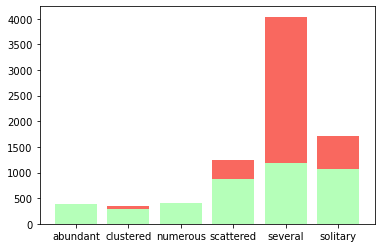

In [24]:
#Population posınous and edıbles graphıcs

print(df.groupby(['population','class'])['class'].count())


abundantEdible = df.groupby(['population','class'])['class'].count()[0]  
abundantPosionus = 0
abundant = abundantEdible + abundantPosionus

clusteredEdible = df.groupby(['population','class'])['class'].count()[1]  
clusteredPosionus = df.groupby(['population','class'])['class'].count()[2] 
clustered = clusteredEdible + clusteredPosionus

numerousEdible = df.groupby(['population','class'])['class'].count()[3]  
numerousPosionus = 0
numerous = numerousEdible + numerousPosionus

scatteredEdible = df.groupby(['population','class'])['class'].count()[4]  
scatteredPosionus = df.groupby(['population','class'])['class'].count()[5]
scattered = scatteredEdible + scatteredPosionus

severalEdible = df.groupby(['population','class'])['class'].count()[6]  
severalPosinous  = df.groupby(['population','class'])['class'].count()[7]  
several = severalEdible + severalPosinous

solitaryEdible = df.groupby(['population','class'])['class'].count()[8]  
solitaryPosionus = df.groupby(['population','class'])['class'].count()[9]
solitary = solitaryEdible + solitaryPosionus

greenBars = [abundantEdible, clusteredEdible,  numerousEdible, scatteredEdible, severalEdible, solitaryEdible]
redBars = [abundantPosionus, clusteredPosionus, numerousPosionus, scatteredPosionus, severalPosinous, solitaryPosionus]

r = ['abundant', 'clustered', 'numerous', 'scattered','several', 'solitary']
plt.bar(r, greenBars, color='#b5ffb9')
plt.bar(r, redBars, bottom=greenBars, color='#F9685F')


print('abundant population Mushrooms\'', abundantEdible / abundant * 100 ,'% are edible.')
print('clustered population Mushrooms\'', clusteredEdible / clustered * 100 ,'% are edible.')
print('numerous population Mushrooms\'', numerousEdible / numerous * 100 ,'% are edible.')
print('scattered population Mushrooms\'', scatteredEdible / scattered * 100 ,'% are edible.')
print('several population Mushrooms\'', severalEdible / several * 100 ,'% are edible.')
print('solitary population Mushrooms\'', solitaryEdible / solitary * 100 ,'% are edible.')

habitat  class
d        e        1880
         p        1268
g        e        1408
         p         740
l        e         240
         p         592
m        e         256
         p          36
p        e         136
         p        1008
u        e          96
         p         272
w        e         192
Name: class, dtype: int64
woods habitat Mushrooms' 59.720457433290974 % are edible.
grasses habitat Mushrooms' 65.54934823091247 % are edible.
leaves habitat Mushrooms' 28.846153846153843 % are edible.
meadows habitat Mushrooms' 87.67123287671232 % are edible.
paths habitat Mushrooms' 11.888111888111888 % are edible.
urban habitat Mushrooms' 26.08695652173913 % are edible.
waste habitat Mushrooms' 100.0 % are edible.


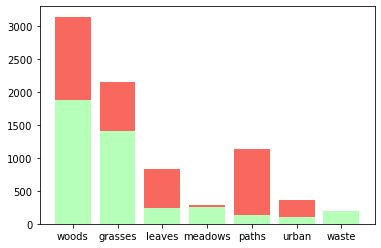

In [25]:
#Habitat posınous and edıbles graphıcs

print(df.groupby(['habitat','class'])['class'].count())


woodsEdible = df.groupby(['habitat','class'])['class'].count()[0]  
woodsPosionus = df.groupby(['habitat','class'])['class'].count()[1]
woods = woodsEdible + woodsPosionus

grassesEdible = df.groupby(['habitat','class'])['class'].count()[2]  
grassesPosionus = df.groupby(['habitat','class'])['class'].count()[3] 
grasses = grassesEdible + grassesPosionus


leavesEdible = df.groupby(['habitat','class'])['class'].count()[4]  
leavesPosionus = df.groupby(['habitat','class'])['class'].count()[5] 
leaves = leavesEdible + leavesPosionus

meadowsEdible = df.groupby(['habitat','class'])['class'].count()[6]  
meadowsPosionus = df.groupby(['habitat','class'])['class'].count()[7]
meadows = meadowsEdible + meadowsPosionus

pathsEdible = df.groupby(['habitat','class'])['class'].count()[8]  
pathsPosinous  = df.groupby(['habitat','class'])['class'].count()[9]  
paths = pathsEdible + pathsPosinous

urbanEdible = df.groupby(['habitat','class'])['class'].count()[10]  
urbanPosionus = df.groupby(['habitat','class'])['class'].count()[11]
urban = urbanEdible + urbanPosionus

wasteEdible = df.groupby(['habitat','class'])['class'].count()[12]  
wastePosionus = 0
waste = wasteEdible + wastePosionus

greenBars = [woodsEdible, grassesEdible,  leavesEdible, meadowsEdible, pathsEdible, urbanEdible, wasteEdible]
redBars = [woodsPosionus, grassesPosionus, leavesPosionus, meadowsPosionus, pathsPosinous, urbanPosionus, wastePosionus]

r = ['woods', 'grasses', 'leaves', 'meadows','paths', 'urban', 'waste']
plt.bar(r, greenBars, color='#b5ffb9')
plt.bar(r, redBars, bottom=greenBars, color='#F9685F')


print('woods habitat Mushrooms\'', woodsEdible / woods * 100 ,'% are edible.')
print('grasses habitat Mushrooms\'', grassesEdible / grasses * 100 ,'% are edible.')
print('leaves habitat Mushrooms\'', leavesEdible / leaves * 100 ,'% are edible.')
print('meadows habitat Mushrooms\'', meadowsEdible / meadows * 100 ,'% are edible.')
print('paths habitat Mushrooms\'', pathsEdible / paths * 100 ,'% are edible.')
print('urban habitat Mushrooms\'', urbanEdible / urban * 100 ,'% are edible.')
print('waste habitat Mushrooms\'', wasteEdible / waste * 100 ,'% are edible.')

## Models

### k-Nearest Neighbors

In [26]:
y_prediction, y_test = apply_model(sklearn.neighbors.KNeighborsClassifier(), X, y)
display(f'Accuracy = {sklearn.metrics.accuracy_score(y_prediction, y_test)}')

'Accuracy = 1.0'

### Decision Tree

In [6]:
y_prediction, y_test = apply_model(sklearn.tree.DecisionTreeClassifier(), X, y)
display(f'Accuracy = {sklearn.metrics.accuracy_score(y_prediction, y_test)}')

'Accuracy = 1.0'

### Random Forest

In [7]:
y_prediction, y_test = apply_model(sklearn.ensemble.RandomForestClassifier(), X, y)
display(f'Accuracy = {sklearn.metrics.accuracy_score(y_prediction, y_test)}')


'Accuracy = 1.0'